In [388]:
import pandas as pd
import pickle
import numpy as np
import os
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model
from keras.utils import np_utils
import random
from keras.preprocessing import image, sequence
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [389]:
images_dir = os.listdir("../input/flickr8k/flickr_data/Flickr_Data/")
images_path = '../input/flickr8k/flickr_data/Flickr_Data/Images/'
captions_path = '../input/flickr8k/flickr_data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
train_path = '../input/flickr8k/flickr_data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
val_path = '../input/flickr8k/flickr_data/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt'
test_path = '../input/flickr8k/flickr_data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_val = open(val_path, 'r').read().split("\n")
x_test = open(test_path, 'r').read().split("\n")

In [390]:
len(x_train)

6001

In [391]:
print(len(captions))
captions[:3]

40461


['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .']

In [392]:
tokens = {}

for ix in range(len(captions)-1):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]

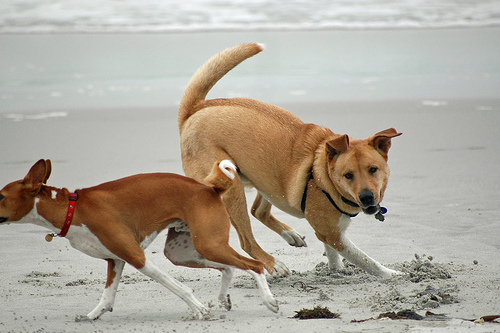

Two different breeds of brown and white dogs play on the beach .
Two dogs are making a turn on a soft sand beach .
Two dogs playing in the sand at the beach .
Two dogs playing together on a beach .
Two large tan dogs play along a sandy beach .


In [393]:
from IPython.display import Image, display
temp = captions[100].split("#")
z = Image(filename=images_path+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])

In [394]:
x_imgs=[]
captions=[]
for img in x_train:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        x_imgs.append(img)
        captions.append(caption)

In [395]:
data={'images':x_imgs,'captions':captions}
df=pd.DataFrame(data)
df.head()

,images,captions
0,2513260012_03d33305cf.jpg,<start> A black dog is running after a white d...
1,2513260012_03d33305cf.jpg,<start> Black dog chasing brown dog through sn...
2,2513260012_03d33305cf.jpg,<start> Two dogs chase each other across the s...
3,2513260012_03d33305cf.jpg,<start> Two dogs play together in the snow . <...
4,2513260012_03d33305cf.jpg,<start> Two dogs running through a low lying b...


In [396]:
words = [i.split() for i in captions]
unique = []
for i in words:
    unique.extend(i)
unique = list(set(unique))
print(len(unique))
vocab_size = len(unique)

8253


In [397]:
word_2_indices = {val:index for index, val in enumerate(unique)}
indices_2_word = {index:val for index, val in enumerate(unique)}

In [398]:
word_2_indices['UNK'] = 0
indices_2_word[0] = 'UNK'

In [399]:
with open( "w2i.p", "wb" ) as pickle_f:
    pickle.dump(word_2_indices, pickle_f )
with open( "i2w.p", "wb" ) as pickle_f:
    pickle.dump(indices_2_word, pickle_f )

In [400]:
with open('../input/img-cap-w2i-i2w/w2i (2).p', 'rb') as f:
    word_2_indices= pickle.load(f, encoding="bytes")
with open('../input/img-cap-w2i-i2w/i2w (2).p', 'rb') as f:
    indices_2_word= pickle.load(f, encoding="bytes")

In [401]:
vocab_size = len(word_2_indices.keys())
print(vocab_size)

8254


In [402]:
max_len = 0
for i in captions:
    i = i.split()
    if len(i) > max_len:
        max_len = len(i)

print(max_len)

40


In [403]:
model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')
#model.summary()

In [404]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [ ]:
imgs={}
for i in tqdm(x_train[:6000]):
    if i in imgs.keys():
        continue
    path = images_path + i
    img = preprocessing(path)
    pred = model.predict(img).reshape(2048)
    imgs[i]=pred

In [182]:
len(imgs)

6000

In [ ]:
with open( "proces_imgs_icep.p", "wb" ) as pickle_f:
    pickle.dump(imgs, pickle_f )

In [405]:
with open('../input/img-cap-63-acc-model/proces_imgs.p', 'rb') as f:
    imgs= pickle.load(f, encoding="bytes")

In [406]:
img = []
for j in tqdm(range(df.shape[0])):
    if df.iloc[j, 0] in imgs.keys():
        img.append(imgs[df.iloc[j, 0]])

img = np.asarray(img)
print(img.shape)

100%|██████████| 30000/30000 [00:01<00:00, 15063.70it/s]


(30000, 2048)


In [407]:
embedding_size = 128
image_model = Sequential()
image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 128)               262272    
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 40, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________


In [408]:
language_model = Sequential()
language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 40, 128)           1056512   
_________________________________________________________________
lstm_24 (LSTM)               (None, 40, 256)           394240    
_________________________________________________________________
time_distributed_8 (TimeDist (None, 40, 128)           32896     
Total params: 1,483,648
Trainable params: 1,483,648
Non-trainable params: 0
_________________________________________________________________


In [409]:
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_8_input (InputLayer)  [(None, 40)]         0                                            
__________________________________________________________________________________________________
dense_22_input (InputLayer)     [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 40, 128)      1056512     embedding_8_input[0][0]          
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 128)          262272      dense_22_input[0][0]             
______________________________________________________________________________________

In [410]:
from keras.utils import to_categorical

In [411]:
def tr_gen(inp_imgs,captions,batch_photos=256):
    x1, x2, y = list(), list(), list()
    n=0
    while True:
        for i in range(df.shape[0]):
            n+=1
            photo=inp_imgs[i]
            text = captions[i].split()
            text = [word_2_indices[i] for i in text]
            for j in range(1, len(text)):
                partial_seqs=text[:j]
                next_words=text[j]
                padded_partial_seqs = sequence.pad_sequences([partial_seqs], 40, padding='post')[0]
                next_words = to_categorical([next_words], num_classes=vocab_size)[0]
                x1.append(photo)
                x2.append(padded_partial_seqs)
                y.append(next_words)
            if n==batch_size:
                yield [np.array(x1), np.array(x2)], np.array(y)
                x1, x2, y = list(), list(), list()
                n=0

In [412]:
train_gen=tr_gen(img,captions,batch_photos=256)

In [413]:
from tensorflow.keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('best_model_acc.h5', monitor = 'accuracy' , mode = 'max', verbose = 1 , save_best_only = True)

In [327]:
hist=model.fit_generator(train_gen,steps_per_epoch=117,callbacks = [mc],epochs=100)

Epoch 1/100
117/117 [==============================] - ETA: 0s - loss: 0.4010 - accuracy: 0.8673
Epoch 00001: accuracy improved from -inf to 0.86725, saving model to best_model_acc.h5
117/117 [==============================] - 54s 460ms/step - loss: 0.4010 - accuracy: 0.8673
Epoch 2/100
117/117 [==============================] - ETA: 0s - loss: 0.3812 - accuracy: 0.8718
Epoch 00002: accuracy improved from 0.86725 to 0.87184, saving model to best_model_acc.h5
117/117 [==============================] - 54s 457ms/step - loss: 0.3812 - accuracy: 0.8718
Epoch 3/100
117/117 [==============================] - ETA: 0s - loss: 0.3784 - accuracy: 0.8730
Epoch 00003: accuracy improved from 0.87184 to 0.87297, saving model to best_model_acc.h5
117/117 [==============================] - 53s 452ms/step - loss: 0.3784 - accuracy: 0.8730
Epoch 4/100
117/117 [==============================] - ETA: 0s - loss: 0.3768 - accuracy: 0.8732
Epoch 00004: accuracy improved from 0.87297 to 0.87319, saving model 

KeyboardInterrupt: 

In [414]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [415]:
def get_encoding(model, img):
    image = preprocessing(img)
    pred = model.predict(image).reshape(2048)
    return pred

In [416]:
resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

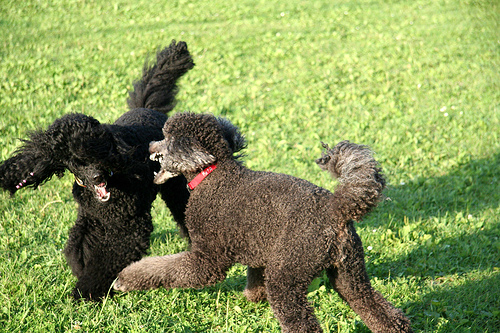

Two dogs wrestle in the grass .


In [490]:
im = '../input/flickr8k/flickr_data/Flickr_Data/Images/'+x_test[121]
test_img = get_encoding(resnet, im)
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word_2_indices[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = indices_2_word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

Argmax_Search = predict_captions(test_img)
z = Image(filename=im)
display(z)

print(Argmax_Search)